# Create CVR distribution charts with alpha and p-value

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import sys
import os

## Generate synthetic data with data_generator to test the function   

data generator: https://github.com/dzianissokalau/data_generator

In [2]:
sys.path.append(os.path.realpath('../../'))
import data_generator

# define parameters for control group
params_control = {
    'dates': {
        'date': {
            'start': '2021-03-01',
            'end': '2021-03-14'
        }
    },
    'values': {
        'payment': {
            'distribution': 'binomial',
            'parameters': {
                'n': 1, 
                'p': 0.2
            },
            'indices': False
        }
    }
}

# define parameters for experimental
params_exp = {
    'dates': {
        'date': {
            'start': '2021-03-01',
            'end': '2021-03-14'
        }
    },
    'values': {
        'payment': {
            'distribution': 'binomial',
            'parameters': {
                'n': 1, 
                'p': 0.22
            },
            'indices': False
        }
    }
}


# create data
control = data_generator.create_dataset(rows=2000, params=params_control, seed=1)
experimental = data_generator.create_dataset(rows=2000, params=params_exp, seed=1)

## Create chart

In [3]:
def abplot(control, experimental, alpha=0.05):
    """Parameters:
        control, experimental: an array of 1 and 0, where 1 indicates success
    Returns:
        None: plot binomial distribution of experimental and control
    """
    # calculate trials
    control_trials = len(control)
    experimental_trials = len(experimental)
    
    # calculate conversion rates
    control_cvr = control.mean()
    experimental_cvr = experimental.mean()
    
    # calculate standard deviation
    control_std = np.sqrt(1 / control_trials * control_cvr * (1 - control_cvr))
    experimental_std = np.sqrt(1 / experimental_trials * experimental_cvr * (1 - experimental_cvr))
    
    # calculate values for x axis and y axis
    x_control = np.linspace(control_cvr - 4 * control_std, control_cvr + 4 * control_std, 1000)
    x_experimental = np.linspace(experimental_cvr - 4 * experimental_std, experimental_cvr + 4 * experimental_std, 1000)

    y_control = stats.norm(control_cvr, control_std).pdf(x_control)
    y_experimental = stats.norm(experimental_cvr, experimental_std).pdf(x_experimental)
    
    # create plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(x_control, y_control, label='control', color='grey')
    ax.plot(x_experimental, y_experimental, label='experimental', color='green')
    
    ax.fill_between(
        x_control, 0, 
        stats.norm(control_cvr, control_std).pdf(x_control), 
        color='green', alpha=0.25, 
        where=(x_control >= stats.norm(control_cvr, control_std).ppf(1-alpha/2)))

    ax.fill_between(
        x_control, 0, 
        stats.norm(control_cvr, control_std).pdf(x_control), 
        color='green', alpha=0.25, 
        where=(x_control <= stats.norm(control_cvr, control_std).ppf(alpha/2)))
    
    ax.hlines(
        0, 
        xmin=np.min([x_control.min(), x_experimental.min()]), 
        xmax=np.max([x_control.max(), x_experimental.max()]), 
        color='black')
    
    ax.vlines(
        experimental_cvr, 
        ymin=0, 
        ymax=y_experimental.max(), 
        color='grey', linewidth=1, linestyle='--')
    
    ax.vlines(
        stats.norm(control_cvr, control_std).ppf(1-alpha/2), 
        ymin=0, 
        ymax=stats.norm(control_cvr, control_std).pdf(stats.norm(control_cvr, control_std).ppf(1-alpha/2)), 
        color='grey', linewidth=1, linestyle='--')

    ax.vlines(
        stats.norm(control_cvr, control_std).ppf(alpha/2), 
        ymin=0, 
        ymax=stats.norm(control_cvr, control_std).pdf(stats.norm(control_cvr, control_std).ppf(alpha/2)), 
        color='grey', linewidth=1, linestyle='--')
        
    plt.xlabel('cvr')
    plt.show()  

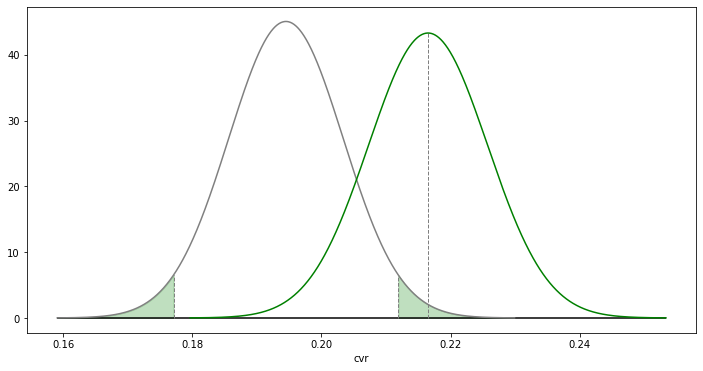

In [4]:
abplot(control.payment, experimental.payment, alpha=0.05)